In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "7"

In [2]:
import contextlib
import requests
import torch
import transformers
from PIL import Image
from pathlib import Path

In [3]:
!echo $CUDA_VISIBLE_DEVICES

7


In [4]:
contextlib.ExitStack().enter_context(torch.inference_mode())

In [5]:
model_name = "llava-hf/llava-1.5-7b-hf"

model = transformers.LlavaForConditionalGeneration.from_pretrained(
    model_name,
    device_map='auto',
    quantization_config=transformers.BitsAndBytesConfig(load_in_8bit=True),
)
processor = transformers.AutoProcessor.from_pretrained(model_name)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

Some kwargs in processor config are unused and will not have any effect: num_additional_image_tokens. 


In [5]:
import os
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import umap

import psutil
import time
from tqdm import tqdm

# Load tensors
def load_tensors(folder):
    data = []
    for file in tqdm(os.listdir(folder)):
        memory_usage = psutil.virtual_memory().percent
        if memory_usage > 90:
            print("Memory usage exceeded 90%. Breaking the loop.")
            break
        if file.endswith(".pt"):  # Assuming tensors are saved as .pt files
            label = file.split('[')[1].split(']')[0]
            try:
                tensor = torch.load(os.path.join(folder, file), map_location='cpu')
            except:
                continue
            data.append((label, tensor))
    return data

# Dimensionality reduction
def reduce_dimension(data, method="PCA", n_components=2):
    flattened_data = []
    labels = []
    for label, tensor in data:
        mean_activation = tensor.mean(dim=0)  # Mean pooling over tokens
        flattened_data.append(mean_activation.detach().numpy())
        labels.append(label)

    flattened_data = np.array(flattened_data)
    if method == "PCA":
        reducer = PCA(n_components=n_components)
    elif method == "TSNE":
        reducer = TSNE(n_components=n_components)
    elif method == "UMAP":
        reducer = umap.UMAP(n_components=n_components, random_state=42)
    else:
        raise ValueError("Unsupported reduction method")
    reduced_data = reducer.fit_transform(flattened_data)
    return reduced_data, labels
    
# Plot
def plot_2d(data, labels, title="Hidden States Visualization"):
    unique_labels = list(set(labels))
    colors = plt.cm.get_cmap("tab10", len(unique_labels))
    plt.figure(figsize=(10, 8))

    for i, label in enumerate(unique_labels):
        indices = [j for j, lbl in enumerate(labels) if lbl == label]
        plt.scatter(data[indices, 0], data[indices, 1], label=label, color=colors(i))

    plt.title(title)
    plt.xlabel("Component 1")
    plt.ylabel("Component 2")
    plt.legend()
    plt.show()

In [6]:
folder_path = "/raid/lawrence/hidden_states/"

In [7]:
tensors = []
for file in tqdm(os.listdir(folder_path)):
    data = np.load(folder_path + file)
    tensor = torch.from_numpy(data['hidden_states'])
    tensors.append(tensor)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [1:09:58<00:00, 41.98s/it]


In [12]:
len(tensors), tensors[0].shape

(100, torch.Size([1000, 592, 4096]))

In [8]:
from collections import defaultdict
def filter(data):
    print(len(data))
    label_to_values = defaultdict(list)
    for label, value in data:
        label_to_values[label].append(value)

    # print([len(value) for key, value in label_to_values.items()])
    
    # Step 2: Filter labels with more than one value
    filtered_labels = {label for label, values in label_to_values.items() if len(values) > 10}
    
    # Step 3: Filter the original list
    filtered_data = [(label, value) for label, value in data if label in filtered_labels]
    print(len(filtered_data))
    return filtered_data

In [ ]:
filtered_data = filter(data)
reduced_data, labels = reduce_dimension(filtered_data, method="UMAP")  # or method="TSNE"
plot_2d(reduced_data, labels)

/tmp/ipykernel_3028387/2710996388.py:54: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10", len(unique_labels))


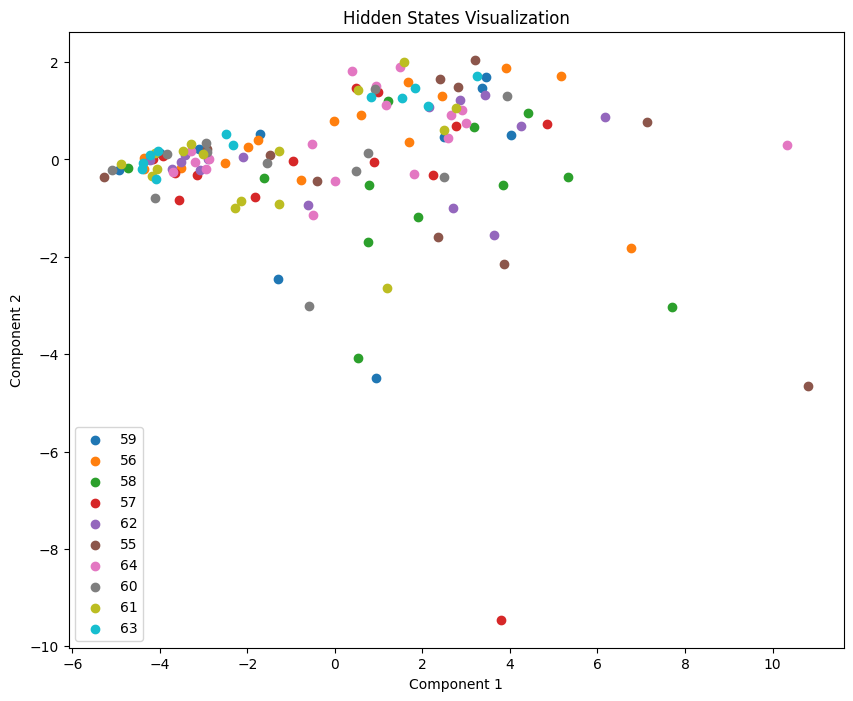

In [42]:
chosen = [str(i) for i in range(55,65)]
filtered_special = [(label, value) for label, value in data if label in chosen]
reduced_data, labels = reduce_dimension(filtered_special, method="PCA")  # or method="TSNE"
plot_2d(reduced_data, labels)

# Hooked Transformer EDA

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "7"

In [5]:
import contextlib
import requests
import torch
import transformer_lens
import transformers
from tempfile import TemporaryDirectory
from PIL import Image

es = contextlib.ExitStack()
es.enter_context(torch.inference_mode())

model_name = "Intel/llava-gemma-2b"
model = transformers.AutoModelForImageTextToText.from_pretrained(
    model_name,
    torch_dtype=torch.float16,
    device_map="auto",
)
processor = transformers.AutoProcessor.from_pretrained(model_name)
processor.patch_size = model.config.vision_config.patch_size
processor.vision_feature_select_strategy = model.config.vision_feature_select_strategy

def get_hooked_model(model, tokenizer):
    with TemporaryDirectory() as model_name:
        model.config.save_pretrained(model_name)
        cfg = transformer_lens.loading.get_pretrained_model_config(
            model_name,
            device=model.device,
            dtype=model.dtype,
        )
        state_dict = transformer_lens.loading.get_pretrained_state_dict(
            model_name,
            cfg,
            model,
        )
        for k, v in state_dict.items():
            if v.device != model.device:
                state_dict[k] = v.to(model.device)
    hooked_model = transformer_lens.HookedTransformer(cfg, tokenizer)
    hooked_model.load_and_process_state_dict(
        state_dict,
        fold_ln=False,
        center_writing_weights=False,
        center_unembed=False,
        fold_value_biases=False,
    )
    return hooked_model

hooked_model = get_hooked_model(model.language_model, processor.tokenizer)

def get_input_embeds(input_ids, pixel_values):
    input_embeds = model.get_input_embeddings()(input_ids)
    image_features = model.get_image_features(
        pixel_values,
        model.config.vision_feature_layer,
        model.config.vision_feature_select_strategy,
    )
    input_embeds[input_ids == model.config.image_token_index] = image_features
    return input_embeds

def run_model(prompt, image):
    inp = processor(image, prompt, return_tensors="pt").to(model.device)
    input_embeds = get_input_embeds(inp.input_ids, inp.pixel_values)
    input_embeds *= hooked_model.cfg.d_model ** 0.5
    return hooked_model.run_with_cache(input_embeds, start_at_layer=0)

conversation = [{"role": "user", "content": processor.image_token + "\nWhere is the water in the image?"}]
prompt = processor.tokenizer.apply_chat_template(conversation, add_generation_prompt=True, tokenize=False)

image = requests.get("https://llava-vl.github.io/static/images/view.jpg", stream=True)
image = Image.open(image.raw)

import sys

# if mode == "A":
#     logits, activations = run_model(prompt, image)
#     print(logits)
#     print(activations)
# else:
#     inp = processor(image, prompt, return_tensors="pt").to(model.device)
#     input_embeds = get_input_embeds(inp.input_ids, inp.pixel_values)

#     if mode == "B":
#         while True:
#             next_token = model.language_model(inputs_embeds=input_embeds, use_cache=False).logits[0, -1].argmax()
#             print(end=processor.tokenizer.decode(next_token), flush=True)
#             input_embeds = torch.cat([input_embeds, model.get_input_embeddings()(next_token).unsqueeze(0).unsqueeze(0)], 1)
#     elif mode == "C":
#         input_embeds *= hooked_model.cfg.d_model ** 0.5
#         while True:
#             next_token = hooked_model(input_embeds, start_at_layer=0)[0, -1].argmax()
#             print(end=processor.tokenizer.decode(next_token), flush=True)
#             input_embeds = torch.cat([input_embeds, hooked_model.embed(next_token).unsqueeze(0).unsqueeze(0)], 1)

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

In [6]:
# from transformer_lens import HookedTransformer
from sae_lens import SAE, HookedSAETransformer
import transformer_lens.utils as utils

# the cfg dict is returned alongside the SAE since it may contain useful information for analysing the SAE (eg: instantiating an activation store)
# Note that this is not the same as the SAEs config dict, rather it is whatever was in the HF repo, from which we can extract the SAE config dict
# We also return the feature sparsities which are stored in HF for convenience.
sae, cfg_dict, sparsity = SAE.from_pretrained(
    release="gemma-2b-res-jb",  # <- Release name
    sae_id="blocks.12.hook_resid_post",  # <- SAE id (not always a hook point!)
    device='cuda:0',
)

In [7]:
encoded = sae.encode(run_model(prompt, image)[1][sae.cfg.hook_name])

# Imagenet

In [8]:
from datasets import load_dataset

imagenet_train = load_dataset('Maysee/tiny-imagenet', split='train')
imagenet_val_combined = load_dataset('Maysee/tiny-imagenet', split='valid')

In [9]:
imagenet_val_test = imagenet_val_combined.train_test_split(test_size=0.5, stratify_by_column='label')
imagenet_val = imagenet_val_test['train']
imagenet_test = imagenet_val_test['test']

In [10]:
import torch
from torch.utils.data import Dataset

class ImageNetDataset(Dataset):
    def __init__(self, huggingface_dataset, transform=None):
        """
        Args:
            huggingface_dataset: Our ImageNet dataset from huggingface
            transform: Potential transformation for the images
        """
        self.dataset = huggingface_dataset
        self.transform = transform

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image = self.dataset[idx]['image']
        label = self.dataset[idx]['label']

        # Apply the transform if specified
        if self.transform:
            image = self.transform(image)

        return image, label, idx

In [ ]:
from torch.utils.data import DataLoader
from tqdm import tqdm 
import h5py
import gzip

from torch.utils.data import DataLoader
from torchvision import transforms

# Example transformation function: this is for use with Vision Transformers
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Lambda(lambda x: x.repeat(3, 1, 1) if x.size(0) == 1 else x), # apparently some images are not RGB
])

train_dataset = ImageNetDataset(imagenet_train, transform=transform)
train_dataloader = DataLoader(train_dataset, shuffle=True)

In [ ]:
def gather_activations(c):
    # Create a list of all the images of the class
    class_images
            
    neuron_activations = []
    for image in tqdm(class_images):
        encoded = sae.encode(run_model(prompt, image)[1][sae.cfg.hook_name]).cpu()
        neuron_activations.append(encoded)


In [72]:
activations = []
for c in tqdm(range(200)):
    activations.append(gather_activations(c))

  0%|                                                                                                                       | 0/200 [00:55<?, ?it/s]


KeyboardInterrupt: 

In [56]:
# Gather statistics about neuron activations

import matplotlib.pyplot as plt

stacked = torch.stack(neuron_activations, dim=0)

results = torch.sum(stacked, dim=0).squeeze(0)

In [57]:
results.shape

torch.Size([595, 16384])

In [58]:
torch.topk(results, 10, dim=-1).indices[587]

tensor([12176, 15314,  3539,  8207,  9987, 13614,  9864,  1321, 10063, 12382])

In [60]:
torch.argmax(results, dim=0).shape

torch.Size([16384])

Text(0.5, 1.0, 'Histogram of activations')

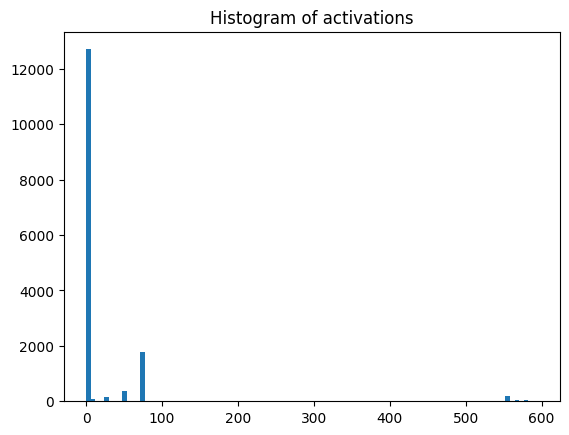

In [52]:
plt.hist(torch.argmax(results, dim=0).numpy(), bins=100)
plt.title("Histogram of activations")